## 載入函數

In [42]:
import time
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
# torch api
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision
from torchsummary import summary
# device add gpu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")       # 使用Nvidia 顯卡

# 一、Model tuning

當模型的效果不佳時，可以嘗試調整以下模型參數架構:

* 學習率 `Learning rate`
* 激勵函數 `Activation function`
* 優化器 `Optimizer`

## 1. 模擬資料集並產生資料集

In [43]:
def linear_model(rseed=222, n_samples=30):
    " Generate data according to a linear model"
    np.random.seed(rseed)

    data = np.float32(np.random.normal(0, 1, (n_samples, 2)))
    data[:n_samples // 2] -= 1.5
    data[n_samples // 2:] += 1.5

    labels = np.int64(np.ones(n_samples))
    labels[:n_samples // 2] = 0

    return data, labels

In [44]:
n_samples = 2000
X, y = linear_model(n_samples = n_samples)

In [45]:
print('X: ', X[:5])
print('y: ', y[:5])

X:  [[ 0.46342504 -1.2242303 ]
 [-1.0413418  -0.4987353 ]
 [-2.2638354  -0.77807236]
 [-2.4054694  -0.49812663]
 [-2.0207424  -1.1910472 ]]
y:  [0 0 0 0 0]


## 2. 資料視覺化

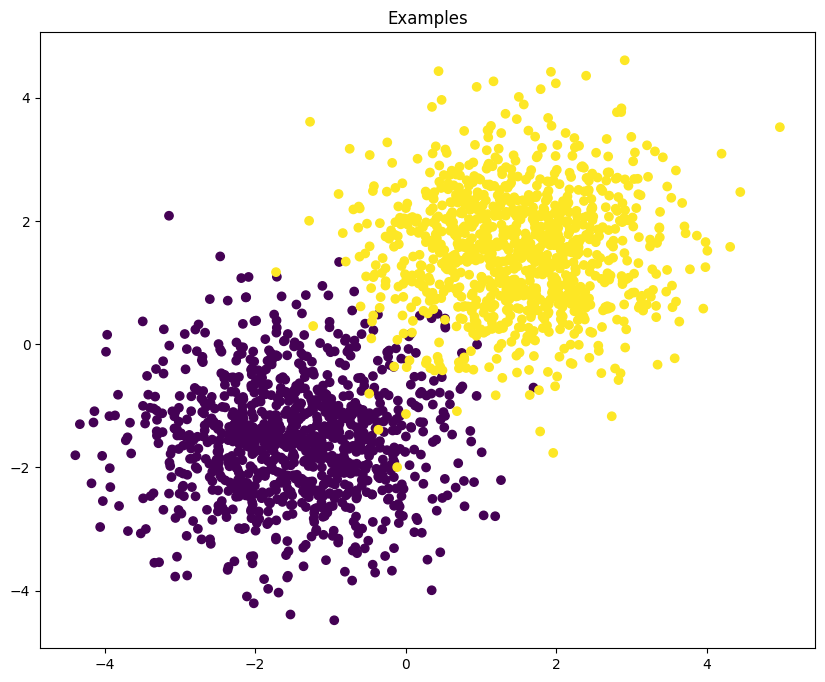

In [46]:
plt.figure(figsize=(10,8))
plt.scatter(X[:,0], X[:,1], c = y)
plt.title('Examples')
plt.show()

## 3. 切割訓練集 (Training set) 以及測試集 (testing set)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True)

print('Training data size: ', X_train.shape)
print('Testing data size: ', X_test.shape)

Training data size:  (1200, 2)
Testing data size:  (800, 2)


In [48]:
# 因為我們要使用 pytorch 的 DataLoader，DataLoader 需要使用到一個包含 __getitem__ 和 __len__ 的 generator
# 使用 generator 的好處是不用一次讀完所有的檔案，可以一次只取部分的資料就好
class Custom_Generator(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data        # 輸入的訓練資料
        self.y_data = y_data        # 輸入訓練資料的標籤

    def __getitem__(self, index):
        data = self.X_data[index]
        target = self.y_data[index]

        return data,target

    def __len__(self):
        return len(self.X_data)     # 回傳資料集數量

In [49]:
# 1. 先將資料放進我們寫好的 Custom_Generator
train_data  = Custom_Generator(X_data = X_train, y_data = y_train)

# 2. 利用 pytorch 的 DataLoader 來做批次 (batch) 動作，模型一次輸入一個 batch
trainloader = DataLoader(train_data, batch_size=32,shuffle=True)

In [50]:
dataiter = iter(trainloader)   # 把 Dataloader 轉成迭代器 (iterator)，就可以用 next 的方式依序取出資料
x_batch, y_batch = next(dataiter)
print(x_batch.shape)
print(y_batch.shape)

torch.Size([32, 2])
torch.Size([32])


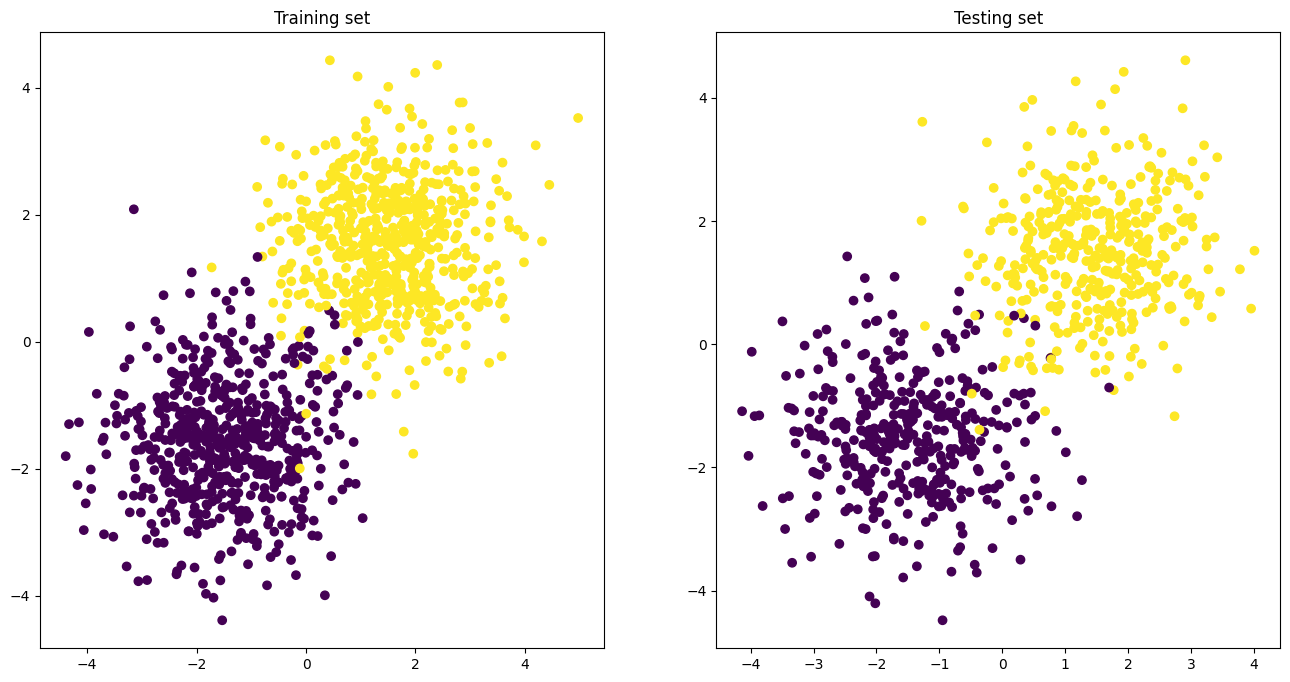

In [51]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.scatter(X_train[:,0], X_train[:,1], c = y_train)
plt.title('Training set')

plt.subplot(1,2,2)
plt.scatter(X_test[:,0], X_test[:,1], c = y_test)
plt.title('Testing set')
plt.show()

## 4. 建立模型

In [52]:
class DNN(nn.Module):
    def __init__(self, input_shape, act = nn.ReLU(inplace=True)):
        super(DNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_features = input_shape, out_features = 32, bias = True),
            act,
            nn.Linear(in_features = 32, out_features = 64, bias = True),
            act,
            nn.Linear(in_features = 64, out_features = 128, bias = True),
            act,
            nn.Linear(in_features = 128, out_features = 64, bias = True),
            act
        )

        self.output = nn.Sequential(nn.Linear(in_features = 64, out_features = 2, bias = True),)
    def forward(self, x):
        x = self.fc(x)
        output = self.output(x)
        return output

In [53]:
model = DNN(input_shape = 2).to(device)
summary(model, input_size = (2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]              96
              ReLU-2                   [-1, 32]               0
            Linear-3                   [-1, 64]           2,112
              ReLU-4                   [-1, 64]               0
            Linear-5                  [-1, 128]           8,320
              ReLU-6                  [-1, 128]               0
            Linear-7                   [-1, 64]           8,256
              ReLU-8                   [-1, 64]               0
            Linear-9                    [-1, 2]             130
Total params: 18,914
Trainable params: 18,914
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.07
Estimated Total Size (MB): 0.08
---------------------------------------------

## 5. Learning rate, optimizer設置

### I. Learning rate

學習率指的是梯度下降公式中的 $\color{red}{\eta}$，$\color{red}{\eta}$ 的大小影響了模型收斂的效率，如下圖：

* Too low: 如最左圖，若學習率太小，模型收斂速度緩慢，導致必須使用比較大的 `Epoch` 才能達到收斂。

* Just right: 如中圖，若學習率適中，模型的收斂速度會比較正常。
* Too high: 如右圖，若學習率過大，則容易在最佳解附近震盪，會發現損失函數值跳來跳去，無法順利下降。

從經驗來說，學習率通常會介於 `0` 至 `1` 之間，並以 `10` 的倍數來調整，例如 `1e-2`,`1e-3`,`1e-4`等等。

$$
\hat{\theta}:=\theta- \color{red}{\eta}\frac{\partial C}{\partial\theta}
$$

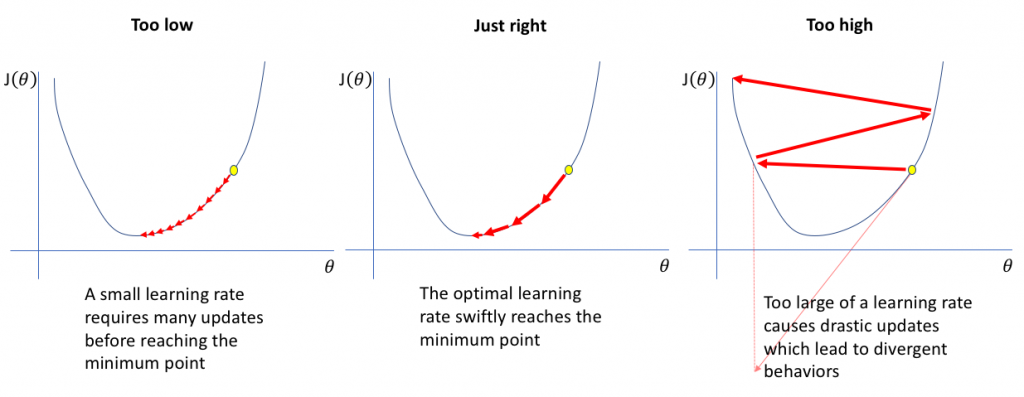

### 訓練流程
1. **設定模型:**  
- 模型架構
- 損失函數
- 優化器  
  
2. **模型訓練:**   
模型輸出 y → 計算 loss → 更新梯度 → 更新參數 → 梯度歸零

In [54]:
## 1. 設定模型

# 將資料放進 GPU
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

# 設定模型，並將模型放進 GPU
model = DNN(input_shape = 2).to(device)

# 設定 loss function
loss_fn = nn.CrossEntropyLoss()

# 設定 optimizer
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

# 初始的隨機參數 W (前五組)
list(model.parameters())[0][:5]

tensor([[ 0.4215, -0.4665],
        [ 0.4167, -0.0180],
        [ 0.4535,  0.1756],
        [ 0.3401, -0.3394],
        [ 0.6304,  0.6345]], grad_fn=<SliceBackward0>)

In [55]:
## 2. 模型訓練

# 計算模型預測的 y 以及 loss 值
y_predict = model(x_batch)
loss = loss_fn(y_predict, y_batch)

# 根據 loss 的計算結果，反向傳播往前更新每個參數 w 的梯度
loss.backward()

# 根據所使用的 optimizer 執行梯度更新的公式，並將梯度歸零
optimizer.step()
optimizer.zero_grad()

# 更新後的參數 W (前五組)
list(model.parameters())[0][:5]

tensor([[ 0.4217, -0.4664],
        [ 0.4165, -0.0181],
        [ 0.4541,  0.1760],
        [ 0.3398, -0.3396],
        [ 0.6308,  0.6350]], grad_fn=<SliceBackward0>)

### 將訓練流程寫成一個函數

In [56]:
# 定義一個訓練 process
def train_process(model, optimizer, epochs, loss_fn, train_data):
    loss_history = []
    acc_history = []

    # 設定每個 epoch 的初始值
    for epoch in tqdm(range(epochs),position=0):
        # 訓練階段
        model.train()  # 切換到訓練模式，可開啟 Dropout 和 BatchNorm 功能
        running_loss = 0.0  # 訓練時的 loss
        n_correct = 0.0  # 總答對筆數
        n_total = 0.0  # 總資料筆數

        # 取出每個 batch 的資料
        for times, (x_batch, y_batch) in enumerate(train_data):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # 模型輸出 y -> 計算 loss -> 更新梯度 -> 更新參數 -> 梯度歸零
            y_output = model(x_batch)
            loss = loss_fn(y_output, y_batch)
            loss.backward()  # pytorch 會記得每個 tensor 的計算過程，所以對任何一個 tensor 都可以使用 .backward()
            optimizer.step()
            optimizer.zero_grad()

            # 將每一筆資料的 loss 都加起來，假設有 100 筆資料就會有 100 個 loss 的結果
            running_loss += loss.item()

            # 計算 Accuracy
            _, y_predict = torch.max(y_output.data, 1)  # 將預測 y 換成類別 (torch.max 會回傳 max_values, max_indices)
            n_total += len(y_batch)
            n_correct += (y_predict == y_batch).sum().item()

            # 當一個 epoch 結束後，顯示結果
            if times+1 == len(train_data):
                loss_history.append(running_loss/len(train_data))
                acc_history.append(n_correct / n_total)
                running_loss = 0.0  # loss 歸零

    print('Finished Training')
    return loss_history, acc_history


In [57]:
# 設定loss function
loss_fn = nn.CrossEntropyLoss()
# 以下放置要比較的 learning rate
lr_list = [0.1, 1e-2, 1e-3, 1e-4]
# 設定訓練的epoch數量
epochs = 20

# 建立兩個 list 記錄選用不同 learning rate 的訓練結果
all_loss = []
all_acc = []

for lr in lr_list:
    print("Running model, learning rate = %f"%(lr))
    model = DNN(input_shape = 2).to(device)
    # 設定優化器，這裡以sgd為例
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    loss, acc = train_process(model = model,
                              optimizer = optimizer,
                              epochs = epochs,
                              loss_fn = loss_fn,
                              train_data = trainloader)
    all_loss.append(loss)
    all_acc.append(acc)

Running model, learning rate = 0.100000


100%|██████████| 20/20 [00:00<00:00, 20.99it/s]


Finished Training
Running model, learning rate = 0.010000


100%|██████████| 20/20 [00:00<00:00, 21.60it/s]


Finished Training
Running model, learning rate = 0.001000


100%|██████████| 20/20 [00:00<00:00, 21.60it/s]


Finished Training
Running model, learning rate = 0.000100


100%|██████████| 20/20 [00:00<00:00, 21.67it/s]

Finished Training


### 視覺化訓練結果

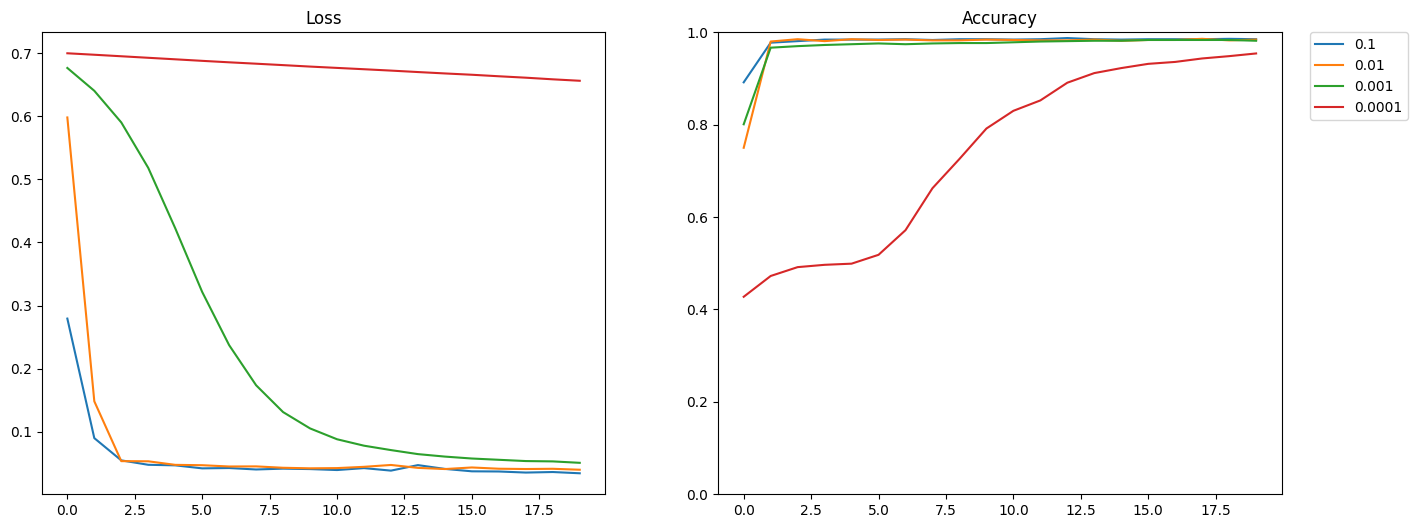

In [58]:
# 視覺化訓練過程
plt.figure(figsize=(16, 6))

# 繪製 Training loss
plt.subplot(121)
for k in range(len(lr_list)):
    plt.plot(range(len(all_loss[k])), all_loss[k], label=lr_list[k])
plt.title('Loss')

# 繪製 Training accuracy
plt.subplot(122)
for k in range(len(lr_list)):
    plt.plot(range(len(all_acc[k])), all_acc[k], label=lr_list[k])
plt.title('Accuracy')

plt.ylim((0, 1))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### II. Activation function

激勵函數最主要的目標在於確保模型去學習非線性的能力，生活中幾乎所有的資料都一定有非線性的性質，也就是無法用一條直線、平面或是高維的平面來劃分，在邊界上都是彎彎曲曲的樣子，這時就需要激勵函數的非線性性質。

比較常見的激勵函數如下圖，在早期比較常用的為 `sigmoid`，但是當模型層數一深的時候，`sigmoid` 會引發 **梯度消失** 的問題，所以後來就鮮少人使用，目前最常用且效果也普遍較好的激勵函數為 `relu`，其優點就是計算快速，只需要簡單計算 $max(0,x)$ 即可，近期還有如 `mish` 這種比較新穎的激勵函數可以使用。

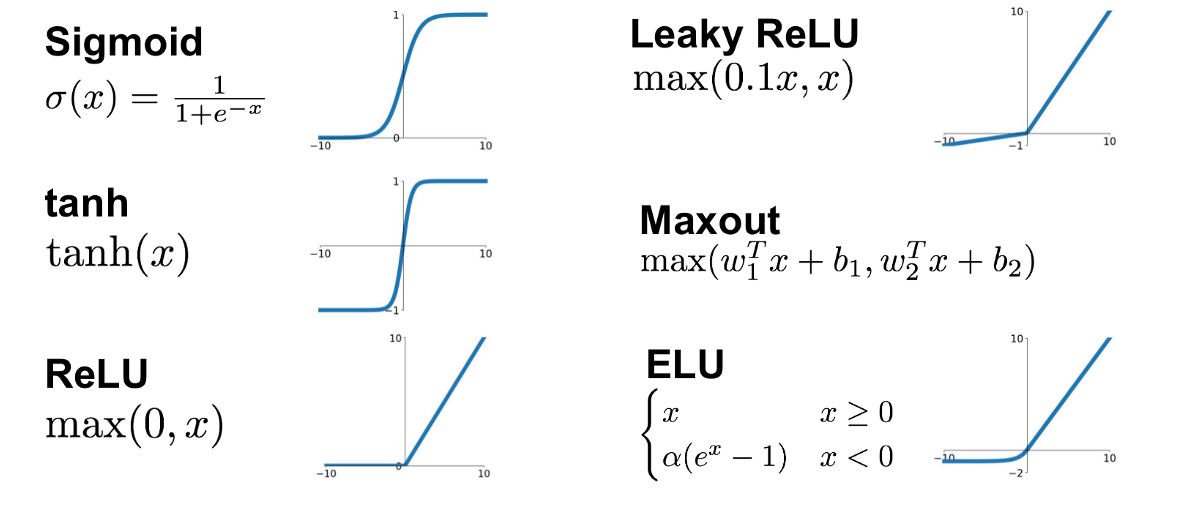

如下圖，[`Mish`](https://arxiv.org/abs/1908.08681) 是 2019 年提出的激勵函數，這個函數比起 `relu` 來說，在 `x` 為負的地方更加平滑，不會像 `relu` 會出現斷層的現象，下下圖中顯示在某一層中， `relu` 和 `Mish` 的梯度分佈，`relu` 的梯度會類似斷層的現象，這會導致模型在學習過程中梯度不穩定，導致收斂效果不彰，而 `Mish` 看起來比較平滑，而這種平滑的特性對於模型來說比較健康。

$$
Mish(x) = x\tanh(\log(1+e^x))
$$

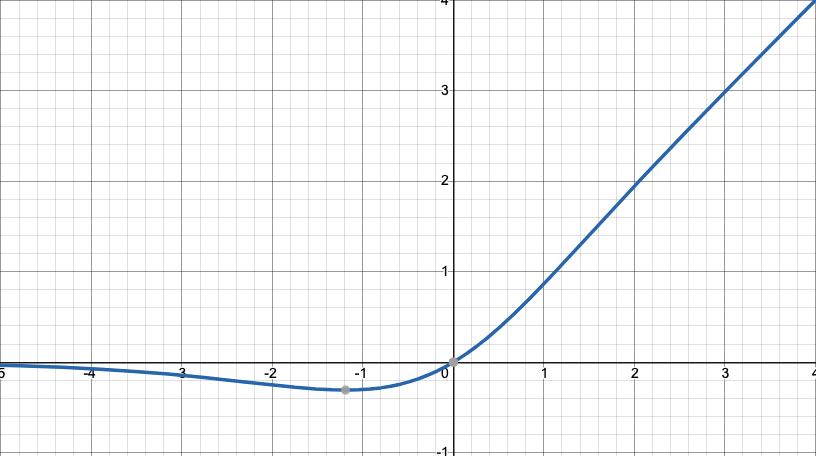

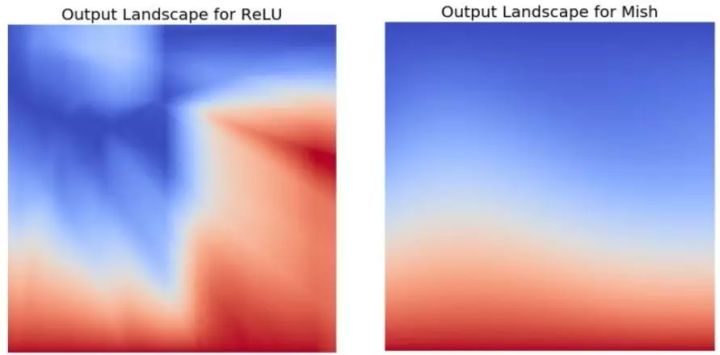

In [59]:
# 設定loss function
criterion = nn.CrossEntropyLoss()
# 設定訓練的epoch數量
epochs = 20
lr = 0.01

# 以下放置要比較的 activation function
acti_dict = {'sigmoid':nn.Sigmoid(),
             'tanh':nn.Tanh(),
             'softplus':nn.Softplus(),
             'relu':nn.ReLU(inplace=True),
             'mish':nn.Mish(inplace=True)}

# 建立兩個 list 記錄選用不同 activation function 的訓練結果
all_loss = []
all_acc = []

for act_name, act_function in acti_dict.items():
    print("Running model, activation function = %s"%(act_name))
    model = DNN(input_shape = 2,act = act_function).to(device)
    # 設定優化器，這裡以sgd為例
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    loss, acc = train_process(model = model,
                              optimizer = optimizer,
                              epochs = epochs,
                              loss_fn = criterion,
                              train_data = trainloader)
    all_loss.append(loss)
    all_acc.append(acc)

Running model, activation function = sigmoid


100%|██████████| 20/20 [00:00<00:00, 21.34it/s]


Finished Training
Running model, activation function = tanh


100%|██████████| 20/20 [00:00<00:00, 21.34it/s]


Finished Training
Running model, activation function = softplus


100%|██████████| 20/20 [00:01<00:00, 18.64it/s]


Finished Training
Running model, activation function = relu


100%|██████████| 20/20 [00:00<00:00, 21.07it/s]


Finished Training
Running model, activation function = mish


100%|██████████| 20/20 [00:01<00:00, 18.12it/s]

Finished Training


### 視覺化訓練結果

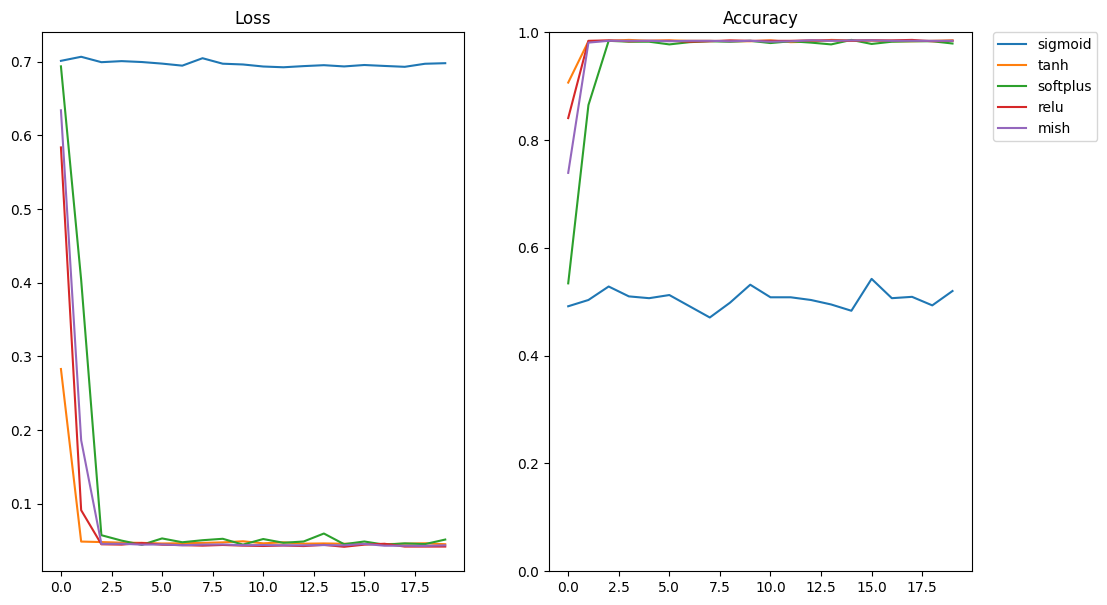

In [60]:
acti_list = ['sigmoid', 'tanh', 'softplus', 'relu', 'mish']

# 視覺化訓練過程
plt.figure(figsize=(12, 7))

# 繪製 Training loss
plt.subplot(121)
for k in range(len(acti_list)):
    plt.plot(range(len(all_loss[k])), all_loss[k], label=acti_list[k])
plt.title('Loss')

# 繪製 Training accuracy
plt.subplot(122)
for k in range(len(acti_list)):
    plt.plot(range(len(all_acc[k])), all_acc[k], label=acti_list[k])
plt.title('Accuracy')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.ylim((0, 1))
plt.show()

### III. Optimizer

優化器在深度學習中負責決定梯度如何更新，在前幾章節所使用的優化器都是 `SGD (Stochastic Gradient Descent)`，這種做法是每次迭代時從資料中隨機拿一筆資料丟給模型預測，接著計算完 loss 之後進行梯度更新，後來才發展成每次隨機拿 `batch_size` 筆的資料來輸入給模型，每次拿 `batch_size` 筆的優點在於可以將資料中的變異抹平：

$$
\hat{\theta}=\theta-\eta\frac{\partial C}{\partial\theta}
$$

後來又陸續有許多新穎的優化器發展出來，最終目標都是為了有效的利用梯度，目前最常使用的優化器是 `RMSprop`, `Adam` 以及 `AdamW`。

西元2020年起，不管是kaggle或是論文發表，都是以`AdamW`做為優化器使用。

### 訓練模型

In [61]:
# 設定loss function
criterion = nn.CrossEntropyLoss()
# 設定訓練的epoch數量
epochs = 20
lr = 0.01

# 以下放置要比較的 optimizer
optim_list = ['SGD', 'Adagrad', 'RMSprop', 'Adam', 'AdamW']

# 建立兩個 list 記錄選用不同 optimizer 的訓練結果
all_loss = []
all_acc = []

for optimizer_name in optim_list:
    print("Running model, optimizer = %s"%(optimizer_name))
    model = DNN(input_shape = 2,act = nn.ReLU(inplace=True)).to(device)
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    elif optimizer_name == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=lr, lr_decay=0, weight_decay=0)

    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0.9)

    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

    elif optimizer_name == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)

    loss, acc = train_process(model = model,
                              optimizer = optimizer,
                              epochs = epochs,
                              loss_fn = criterion,
                              train_data = trainloader)
    all_loss.append(loss)
    all_acc.append(acc)

Running model, optimizer = SGD


100%|██████████| 20/20 [00:00<00:00, 21.37it/s]


Finished Training
Running model, optimizer = Adagrad


100%|██████████| 20/20 [00:01<00:00, 18.37it/s]


Finished Training
Running model, optimizer = RMSprop


100%|██████████| 20/20 [00:01<00:00, 15.80it/s]


Finished Training
Running model, optimizer = Adam


100%|██████████| 20/20 [00:01<00:00, 14.79it/s]


Finished Training
Running model, optimizer = AdamW


100%|██████████| 20/20 [00:01<00:00, 14.04it/s]

Finished Training


### 視覺化訓練結果

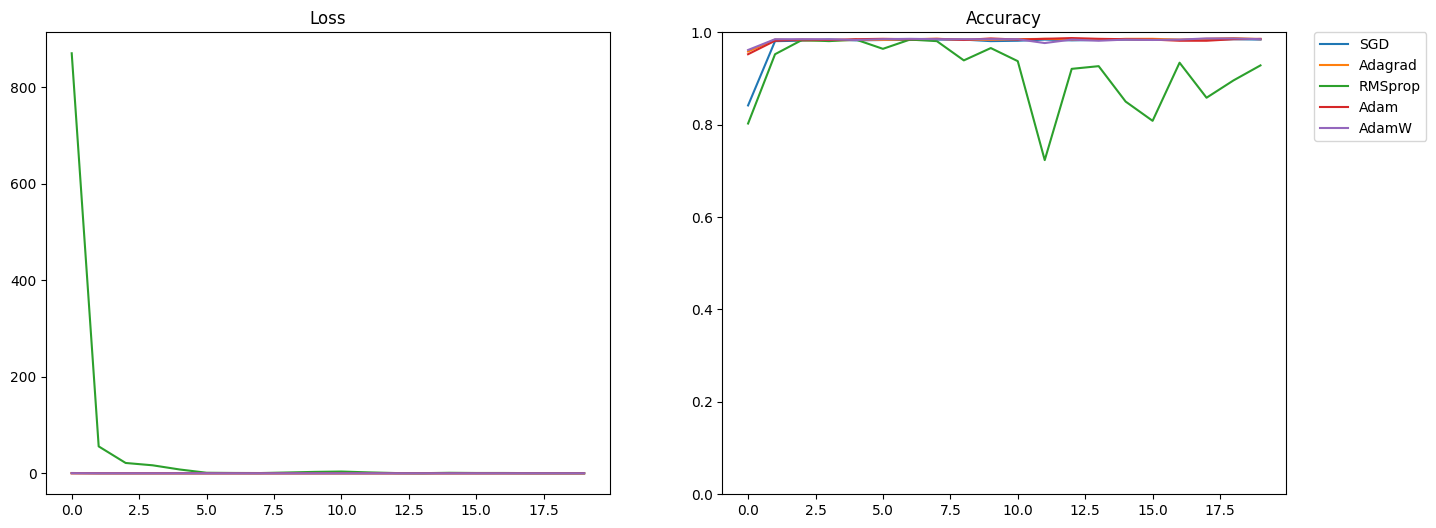

In [62]:
# 視覺化訓練過程
plt.figure(figsize=(16, 6))

# 繪製 Training loss
plt.subplot(121)
for k in range(len(optim_list)):
    plt.plot(range(len(all_loss[k])), all_loss[k], label=optim_list[k])
plt.title('Loss')

# 繪製 Training accuracy
plt.subplot(122)
for k in range(len(optim_list)):
    plt.plot(range(len(all_acc[k])), all_acc[k], label=optim_list[k])
plt.title('Accuracy')


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim((0, 1))
plt.show()

# 二、 動手試試看使用模型來進行一個訓練的流程
請使用下面的資料集 3_non_linear_train.csv 訓練出一個迴歸模型。

## 1. 載入資料

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
# torch api
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision
from torchsummary import summary
# device add gpu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")       # 使用Nvidia 顯卡
device

In [64]:
data = pd.read_csv('3_non_linear_train.csv')

print(data.shape)
data.head()

(200, 2)


,x,y
0,-4.341593,1.403286
1,-4.297456,1.016483
2,-4.253319,1.169736
3,-4.209183,0.701714
4,-4.165046,0.676517


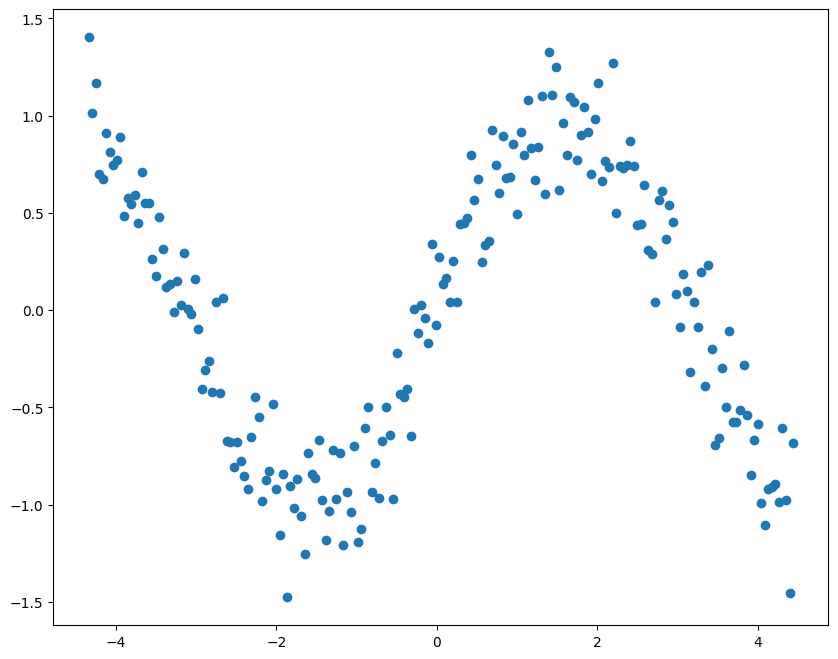

In [ ]:
# 將 x 從資料中挑出來
x = data['x']
# 將 y 從資料中挑出來  
y = data['y']

x = np.float32(x.to_numpy())
y = np.float32(y.to_numpy())

# 資料視覺化
plt.figure(figsize=(10, 8)) #圖表的尺寸
plt.scatter(x, y)
plt.show()

In [66]:
## 建立訓練的generator(後續CNN課程會詳解)，簡單來說因為資料量可能會偏大，所以使用generator可以將所有資料分成n筆資料訓練一次。
class Custom_Generator(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data        # 輸入的訓練資料
        self.y_data = y_data        # 輸入訓練資料的標籤

    def __getitem__(self, index):
        data = self.X_data[index]     # 圖片路徑
        target = self.y_data[index] # 圖片標籤

        return data,target

    def __len__(self):
        return len(self.X_data)     # 回傳資料集數量

In [67]:
# 由於我們的輸入資料的維度一定是(batch, input)，所以要將維度改成二維資料
input_x = np.reshape(x, (-1,1))

# 1. 先呼叫我們寫好的Custom_Generator, 將圖片的路徑陣列、圖片的標籤陣列以及預處理功能放入裡面
train_data  = Custom_Generator(X_data = input_x, y_data = y)

# 2. 呼叫pytorch的DataLoader來做批次動作，模型的輸入
trainloader = DataLoader(train_data, batch_size=1,shuffle=True)

DataLoader 的作用
DataLoader 是 PyTorch 中用於高效加載和處理數據的工具，它將數據集包裝成可迭代的對象。

參數解釋
1. train_data
- 這是要加載的訓練數據集
- 通常是一個 Dataset 對象（如 torch.utils.data.Dataset 的子類）
2. batch_size=1
- 批次大小設為 1
- 意味著每次迭代只取出 1 個樣本
- 這通常用於：
  - 調試階段
  - 內存限制的情況
  - 特殊的訓練策略
1. shuffle=True
- 隨機打亂數據順序
- 每個 epoch 開始時會重新打亂數據
- 好處：
    - 避免模型學習到數據的順序模式
    - 提高訓練的隨機性
    - 通常能獲得更好的泛化性能

## 2. 建立模型
* 這裡不限制用幾層的全連接層，大家可以依照自己的自由去增加或減少
* 記得要加入Activation Function，使用的activation function可以自己去設定

In [68]:
class DNN(nn.Module):
    def __init__(self, input_shape, act=nn.ReLU(inplace=True)):
        super(DNN, self).__init__()
        
        # 建立全連接層序列
        self.fc = nn.Sequential(
            # 第一層：輸入層到第一個隱藏層
            nn.Linear(in_features=input_shape, out_features=64, bias=True),
            act,
            nn.Dropout(0.2),  # 可選：添加dropout防止過度擬合
            
            # 第二層：隱藏層
            nn.Linear(in_features=64, out_features=32, bias=True),
            act,
            nn.Dropout(0.2),
            
            # 第三層：隱藏層
            nn.Linear(in_features=32, out_features=16, bias=True),
            act,
            nn.Dropout(0.2)
        )
        
        # 輸出層 - 修正：回歸任務只需要輸出1個值
        self.output = nn.Linear(in_features=16, out_features=1, bias=True)
    
    def forward(self, x):
        x = self.fc(x)
        output = self.output(x)
        return output

In [69]:
# 修正：輸入維度應該是1，因為我們的數據是一維的
model = DNN(input_shape=1, act=nn.ReLU(inplace=True)).to(device)

print(model)

DNN(
  (fc): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.2, inplace=False)
  )
  (output): Linear(in_features=16, out_features=1, bias=True)
)


## 3. 模型設定

* `loss` 請使用 `mean_squared_error`
* `optimzier` 請使用 `sgd`
* `learning rate` 請自行選擇要使用的大小 ex : lr=0.001

In [70]:
# 設定loss function - 修正：這是回歸問題，應該使用MSELoss
criterion = nn.MSELoss()  # 均方誤差損失函數，適用於回歸任務

# 設定訓練的epoch數量
epochs = 50

# learning rate
lr = 0.001  # 常用的學習率，可以根據訓練效果調整

# 優化器選擇
optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Adam優化器，效果通常很好

## 4. 訓練模型

In [71]:
# 定義一個訓練process
def train_process(model, optimizer, epochs, loss_fn, train_data):
    loss_history = []
    # 第1步驟
    for epoch in tqdm(range(epochs),position=0):
        # 訓練階段
        model.train()
        running_loss = 0.0  # 訓練時的loss
        # 第2步驟
        for times, data_train in enumerate(train_data, 0):  # data_train會包括訓練的資料以及訓練的標籤
            # batch data input
            inputs, labels = data_train
            inputs, labels = inputs.to(device), labels.to(device)
            
            # 確保輸入和標籤的維度正確
            inputs = inputs.float()
            labels = labels.float().view(-1, 1)  # 確保標籤的形狀正確
            
            # 第3步驟
            # Zero the parameter gradients
            optimizer.zero_grad()

            # model Feedforward
            output_train = model(inputs)

            # 第4步驟
            # Feed forward loss result
            loss = loss_fn(output_train, labels)
            # 第5步驟
            # backward update
            loss.backward()

            # 第6步驟
            # optimize
            optimizer.step()

            # 將每一筆資料的loss都加起來，假設有100筆資料就會有100個loss的結果
            # Compute loss
            running_loss += loss.item()

        # 當一個epoch結束後，顯示結果
        loss_history.append(running_loss/len(train_data))
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_data):.4f}')
        
    print('Finished Training')
    return loss_history


In [72]:
# 回歸任務使用MSE損失函數
loss_fn = nn.MSELoss()

# 設定 optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 設定 DataLoader
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)

# 訓練過程
loss = train_process(model=model,
                    optimizer=optimizer,
                    epochs=50,
                    loss_fn=loss_fn,
                    train_data=train_dataloader)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Loss: 0.5408
Epoch [2/50], Loss: 0.5214
Epoch [3/50], Loss: 0.5074
Epoch [4/50], Loss: 0.5204


 16%|█▌        | 8/50 [00:00<00:00, 79.21it/s]

Epoch [5/50], Loss: 0.5737
Epoch [6/50], Loss: 0.5241
Epoch [7/50], Loss: 0.5055
Epoch [8/50], Loss: 0.4482
Epoch [9/50], Loss: 0.4556
Epoch [10/50], Loss: 0.4235
Epoch [11/50], Loss: 0.4294
Epoch [12/50], Loss: 0.4060
Epoch [13/50], Loss: 0.3617
Epoch [14/50], Loss: 0.3804
Epoch [15/50], Loss: 0.3621
Epoch [16/50], Loss: 0.3180
Epoch [17/50], Loss: 0.2862
Epoch [18/50], Loss: 0.2776
Epoch [17/50], Loss: 0.2862
Epoch [18/50], Loss: 0.2776


 36%|███▌      | 18/50 [00:00<00:00, 88.79it/s]

Epoch [19/50], Loss: 0.2734
Epoch [20/50], Loss: 0.2657
Epoch [21/50], Loss: 0.2309
Epoch [22/50], Loss: 0.2034
Epoch [23/50], Loss: 0.2037


 56%|█████▌    | 28/50 [00:00<00:00, 91.76it/s]

Epoch [24/50], Loss: 0.1986
Epoch [25/50], Loss: 0.1968
Epoch [26/50], Loss: 0.1648
Epoch [27/50], Loss: 0.2244
Epoch [28/50], Loss: 0.2044
Epoch [29/50], Loss: 0.2097
Epoch [30/50], Loss: 0.2041
Epoch [31/50], Loss: 0.2068
Epoch [32/50], Loss: 0.1824
Epoch [33/50], Loss: 0.1951
Epoch [34/50], Loss: 0.1461
Epoch [35/50], Loss: 0.1870
Epoch [36/50], Loss: 0.1686
Epoch [37/50], Loss: 0.1625
Epoch [38/50], Loss: 0.1436
Epoch [36/50], Loss: 0.1686
Epoch [37/50], Loss: 0.1625
Epoch [38/50], Loss: 0.1436


 76%|███████▌  | 38/50 [00:00<00:00, 93.14it/s]

Epoch [39/50], Loss: 0.1768
Epoch [40/50], Loss: 0.1746
Epoch [41/50], Loss: 0.1775
Epoch [42/50], Loss: 0.1632
Epoch [43/50], Loss: 0.1441
Epoch [44/50], Loss: 0.1425


100%|██████████| 50/50 [00:00<00:00, 91.91it/s]

Epoch [45/50], Loss: 0.1577
Epoch [46/50], Loss: 0.1438
Epoch [47/50], Loss: 0.1508
Epoch [48/50], Loss: 0.1551
Epoch [49/50], Loss: 0.1433
Epoch [50/50], Loss: 0.1311
Finished Training


## 5. 預測模型

In [73]:
input_x = np.reshape(x, (-1,1))
# 將numpy array轉換成pytorch tensor，並輸入進gpu中
input_x = torch.from_numpy(input_x).float().to(device)

# 模型預測
model.eval()  # 設定為評估模式
with torch.no_grad():
    y_pred = model(input_x)
    
# 將預測結果轉換成numpy格式
y_pred = y_pred.cpu().data.numpy()
y_pred = np.squeeze(y_pred)

In [74]:
y_pred

array([ 0.75924   ,  0.7439338 ,  0.7277484 ,  0.7117984 ,  0.6961328 ,
        0.67961353,  0.6626675 ,  0.6457213 ,  0.6285118 ,  0.61114717,
        0.5937824 ,  0.5764176 ,  0.55905294,  0.5410094 ,  0.5223568 ,
        0.5037042 ,  0.48401672,  0.46348011,  0.44286036,  0.42210138,
        0.40134227,  0.38045442,  0.3570863 ,  0.33128607,  0.30477506,
        0.27773434,  0.24399765,  0.20805259,  0.1721073 ,  0.1356592 ,
        0.09564807,  0.05303575,  0.01042376, -0.03372803, -0.08103194,
       -0.12833574, -0.17563951, -0.22294343, -0.27024716, -0.31755108,
       -0.36485487, -0.41215855, -0.45380753, -0.4926886 , -0.5299371 ,
       -0.56304026, -0.59248155, -0.62190574, -0.6513039 , -0.67846084,
       -0.70179063, -0.72511095, -0.74720997, -0.76440305, -0.7763862 ,
       -0.787516  , -0.79669756, -0.8040365 , -0.80883837, -0.81364036,
       -0.8184422 , -0.8232442 , -0.8264995 , -0.8284442 , -0.8303888 ,
       -0.83233345, -0.83427805, -0.83619094, -0.837803  , -0.83

### 視覺化結果


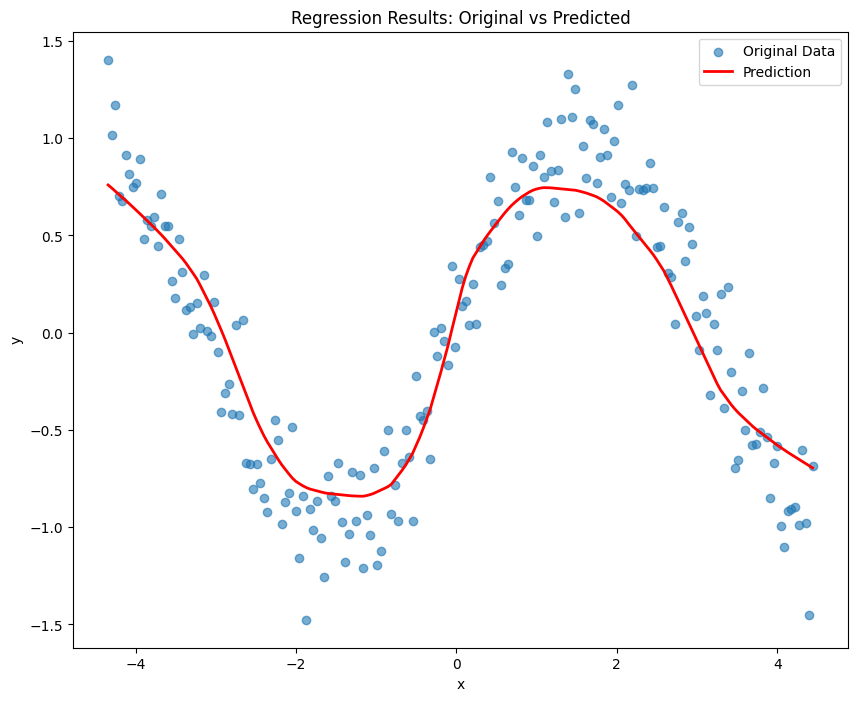

In [75]:
# 資料視覺化
plt.figure(figsize=(10, 8))
plt.scatter(x, y, label='Original Data', alpha=0.6)     # 原始標籤
plt.plot(x, y_pred, color='red', linestyle='-', linewidth=2, label='Prediction') # 預測結果
plt.xlabel('x')
plt.ylabel('y')
plt.title('Regression Results: Original vs Predicted')
plt.legend()
plt.show()